# Alaiz NSC benchmark

## Introduction
This script summarizes the overall results of the [Alaiz NSC benchmark](https://thewindvaneblog.com/numerical-site-calibration-benchmark-the-alaiz-case-b3767918d812).

## Load libraries

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
#import netCDF4 as nc
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
def readExcelToDf(simID, mastName):
    # load raw results into pandas
    
    list_df = []
    # loop on masts
    for k in mastName:

        stab = ['u', 'n', 's']
        filename = './outputs/'+simID+'/'+simID+'_'+k+'.xlsx'
        # loop on stabilities
        for j in range(3):
            
            sheets = ['wind_speed', 'turbulence_intensity']
            variables = dict.fromkeys(sheets)
            for sheet in sheets:
                # read wind speed / turbulence
                try:
                    df_excel = pd.read_excel(open(filename, 'rb'), sheet_name=sheet, usecols="A:K", nrows=6, skiprows=j*8, index_col=None, header=None)
                except:
                    print(filename)
                heights = list(df_excel.iloc[1:,0])
                sectors = list(df_excel.iloc[0,1:])

                list_df_sheet = []
                # loop on sectors
                for i in range(0, len(sectors)):
                    df_tmp = df_excel.iloc[1:,:].copy()
                    df_tmp['ID'] = simID
                    df_tmp['mast'] = re.sub('(A.)_SC.', r'\1', k)
                    try:
                        df_tmp['Sector'] = round(sectors[i])
                    except ValueError:
                        print(filename)
                        print(df_excel)
                    df_tmp['Stability'] = stab[j]
                    df_tmp = df_tmp.rename(columns={0:"z", i+1: sheet})[['ID', 'mast', "Sector", "Stability", "z", sheet]]                           
                    list_df_sheet.append(df_tmp)

                variables[sheet] = pd.concat([a for a in list_df_sheet], axis=0)
                variables[sheet].set_index(['ID', 'mast', 'Sector', 'Stability', 'z'], inplace=True)

            try:
                df_sim = pd.concat([variables[sheet] for sheet in sheets], axis=1)
            except:
                print(filename)
            list_df.append(df_sim)
    
    return list_df

## Results

### Load results

In [3]:
list_df = []

simIDs = ['les122', 'rans135a', 'rans135b', 'rans135c', 'wasp949', 'wt110', 'wt168', 'wt194', 'wt324', 'wt363', 'wt949']
list_df = []

for simID in simIDs:
    if simID == 'wt168':
        mastName = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5_SC1', 'MP5_SC2']
    elif simID in ['rans135a', 'rans135b', 'rans135c']:
        mastName = ['A1_SC2', 'A2_SC2', 'A3_SC2', 'A4_SC1', 'A5_SC1', 'A6_SC1', 'MP5_SC1', 'MP5_SC2']
    else:
        mastName = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5']
    list_df += readExcelToDf(simID, mastName)        

# concatenate all dataframes.
df_sims = pd.concat([a for a in list_df], axis=0)
df_sims

wind_speed  turbulence_intensity
ID     mast Sector Stability z                                    
les122 A1   1      u         118    8.686719              0.094608
                             102    8.661139              0.097817
                             90     8.619283              0.100399
                             78     8.543717              0.104232
                             40     7.831361              0.120607
...                                      ...                   ...
wt949  MP5  36     s         118    7.617754              0.049562
                             102    7.482194              0.050890
                             90     7.404527              0.052860
                             78     7.198442              0.055455
                             40     6.653115              0.068975

[12150 rows x 2 columns]

In [4]:
df_sims.loc['rans135a']

wind_speed  turbulence_intensity
mast    Sector Stability z                                    
A1      1      u         118   10.292081              0.069773
                         102    9.723144              0.084176
                         90    10.339586              0.072783
                         78    10.003519              0.079149
                         40     9.149437              0.107771
...                                  ...                   ...
MP5_SC2 36     s         118    7.289632              0.041499
                         102    7.710933              0.046097
                         90     7.371503              0.046016
                         78     7.304823              0.049857
                         40     6.702283              0.065264

[1200 rows x 2 columns]

### Test with xarray Dataset

In [5]:
# convert to xarray dataset.
ds_sims = xr.Dataset.from_dataframe(df_sims)
ds_sims = ds_sims.sortby(ds_sims.z, ascending=False)
ds_sims["Sector"] = ds_sims.Sector.astype(str)
ds_sims["flow_correction_factor"] = ds_sims["wind_speed"].copy()

simtype = []
for simID in ds_sims.ID.values:
    simtype.append('rans' if ('wt' in simID or 'rans' in simID) else 'les' if 'les' in simID else 'linear' if 'wasp' in simID else '')
ds_sims.coords["simtype"] = ("ID", simtype)

ds_sims

<xarray.Dataset>
Dimensions:                 (ID: 11, Sector: 10, Stability: 3, mast: 9, z: 5)
Coordinates:
  * ID                      (ID) object 'les122' 'rans135a' ... 'wt363' 'wt949'
  * mast                    (mast) object 'A1' 'A2' 'A3' ... 'MP5_SC1' 'MP5_SC2'
  * Sector                  (Sector) <U21 '1' '2' '3' '16' ... '20' '35' '36'
  * Stability               (Stability) object 'n' 's' 'u'
  * z                       (z) int64 118 102 90 78 40
    simtype                 (ID) <U6 'les' 'rans' 'rans' ... 'rans' 'rans'
Data variables:
    wind_speed              (ID, mast, Sector, Stability, z) float64 9.483 .....
    turbulence_intensity    (ID, mast, Sector, Stability, z) float64 0.08691 ...
    flow_correction_factor  (ID, mast, Sector, Stability, z) float64 9.483 .....

### Flow correction factor (FCF)

In [6]:
for simID in ds_sims.ID.values:
    if simID in ['wt168', 'rans135a', 'rans135b', 'rans135c']:
        ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast=['A1', 'A2', 'A3', 'MP5_SC2'])] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5_SC2', z=118)]
        ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast=['A4', 'A5', 'A6', 'MP5_SC1'])] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5_SC1', z=118)]
    elif simID in ['wt110', 'wt363']:
        ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast='MP5')] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5', z=118)]
    else:
        ds_sims["flow_correction_factor"].loc[dict(ID=simID)] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5', z=118)]
        
print(ds_sims.sel(ID='rans135a', mast='A1', Stability='n', Sector='1')['flow_correction_factor'])

<xarray.DataArray 'flow_correction_factor' (z: 5)>
array([0.91726715, 0.88998843, 0.88229731, 0.85123546, 0.75499176])
Coordinates:
    ID         <U8 'rans135a'
    mast       <U2 'A1'
    Sector     <U21 '1'
    Stability  <U1 'n'
  * z          (z) int64 118 102 90 78 40
    simtype    <U6 'rans'


### Load observation data

In [7]:
fnList = ['A1_SC2.nc', 'A2_SC2.nc', 'A3_SC2.nc', 'A4_SC1.nc', 'A5_SC1.nc', 'A6_SC1.nc']

obs = dict.fromkeys([fn[0:2] for fn in fnList])

ds_all = ds_sims.copy()
for fn in fnList:
    mast = fn[0:2]
    obs[mast] = xr.open_dataset('./results/'+fn)
    obs[mast] = obs[mast].assign_coords(ID='obs')
    obs[mast] = obs[mast].expand_dims('ID')
    obs[mast].coords["simtype"] = ("ID", ['obs'])
    obs[mast] = obs[mast].assign_coords(mast=mast[0:2])
    obs[mast] = obs[mast].expand_dims('mast')
    ds_all = xr.merge([ds_all, obs[mast]])

northSectors = ['1', '2', '3', '35', '36']
southSectors = ['16', '17', '18', '19', '20']
norsSectors = northSectors + southSectors
nors = []
for sec in ds_all.coords["Sector"]:
    nors.append('North' if sec in northSectors else 'South' if sec in southSectors else '')
ds_all.coords["nors"] = ("Sector", nors)

ds_all["Sector"] = ds_all.Sector.astype(int)
ds_all = ds_all.sortby(ds_all.Sector, ascending=True)
ds_all["Sector"] = ds_all.Sector.astype(str)
ds_all['samples'] = ds_all.sel(ID='obs')['samples']

### Error calculation

In [8]:
ds_all['error'] = abs(ds_all['flow_correction_factor'] - ds_all['flow_correction_factor'].sel(ID='obs'))/ds_all['flow_correction_factor'].sel(ID='obs')
ds_error = ds_all.sel(Sector=norsSectors)

# weighted mean error
ds_error['errorw'] = ds_error['error']*ds_error['samples']
ds_error['errorw'] = ds_error['errorw'].sum(dim='Sector') / ds_error['samples'].sum(dim='Sector')

### Back to pandas Dateframe for plotting

In [9]:
df_error = ds_error.sel(z=118)[['error', 'errorw']].to_dataframe()
df_error = df_error.drop(columns=['z'])
df_error = df_error.reset_index()
df_error = df_error[df_error.ID != 'obs']
df_error = df_error[df_error.error.notna()]

df_error = df_error.replace({'Stability': 'u'}, 'Unstable')
df_error = df_error.replace({'Stability': 'n'}, 'Neutral')
df_error = df_error.replace({'Stability': 's'}, 'Stable')

#df_error.Sector = df_error.Sector.astype('int')
df_error

,ID,Sector,Stability,mast,error,errorw,simtype,nors
0,les122,1,Neutral,A1,0.149430,0.093376,les,North
1,les122,1,Neutral,A2,0.122523,0.097163,les,North
2,les122,1,Neutral,A3,0.108643,0.103616,les,North
3,les122,1,Neutral,A4,0.098481,0.119253,les,North
4,les122,1,Neutral,A5,0.084115,0.097763,les,North
...,...,...,...,...,...,...,...,...
3232,wt949,20,Unstable,A2,0.035490,0.062688,rans,South
3233,wt949,20,Unstable,A3,0.076588,0.063875,rans,South
3234,wt949,20,Unstable,A4,0.037877,0.046482,rans,South
3235,wt949,20,Unstable,A5,0.018822,0.046490,rans,South


In [10]:
print(obs['A1'].sel(ID='obs', mast='A1', Stability='n', Sector='2')['flow_correction_factor'])

<xarray.DataArray 'flow_correction_factor' (z: 4)>
array([1.0423006 , 1.01884971, 1.01145292, 0.98303101])
Coordinates:
    Sector     <U1 '2'
    Stability  <U1 'n'
  * z          (z) int64 118 102 90 78
    ID         <U3 'obs'
    simtype    <U3 'obs'
    mast       <U2 'A1'
Attributes:
    comments:  mean value of binned flow correction factor


In [11]:
ds_all.sel(ID='obs', mast='A1', Stability='n')['samples']

<xarray.DataArray 'samples' (Sector: 36)>
array([248., 102.,  24.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   4.,  11.,  85., 121., 124.,  64.,  21.,  10.,   5.,
         7.,  17.,  23.,  22.,  35.,  55.,  16.,  18.,  25.,  37.,  49.,
       131., 142., 271.])
Coordinates:
    ID         <U3 'obs'
  * Sector     (Sector) <U11 '1' '2' '3' '4' '5' ... '32' '33' '34' '35' '36'
    Stability  <U1 'n'
    mast       <U2 'A1'
    simtype    object 'obs'
    nors       (Sector) <U5 'North' 'North' 'North' '' ... '' '' 'North' 'North'
Attributes:
    comments:  number of 10-min samples

In [12]:
df_error.groupby(['ID', 'simtype']).mean().sort_values(by=['errorw'])

,,error,errorw
ID,simtype,,
rans135c,rans,0.055831,0.051241
wt949,rans,0.054905,0.053603
rans135a,rans,0.062452,0.054773
rans135b,rans,0.063143,0.055696
wasp949,linear,0.056420,0.056647
wt110,rans,0.058849,0.058085
wt363,rans,0.059316,0.058547
wt168,rans,0.062624,0.060834
wt194,rans,0.072976,0.064572


          ID     error    errorw
0   rans135c  0.055831  0.051241
1      wt949  0.054905  0.053603
2   rans135a  0.062452  0.054773
3   rans135b  0.063143  0.055696
4    wasp949  0.056420  0.056647
5      wt110  0.058849  0.058085
6      wt363  0.059316  0.058547
7      wt168  0.062624  0.060834
8      wt194  0.072976  0.064572
9      wt324  0.068823  0.069505
10    les122  0.103054  0.094638


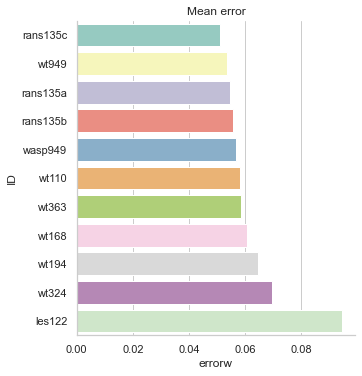

In [13]:
df_plot = df_error.groupby(['ID']).mean().sort_values(by=['errorw']).reset_index()
print(df_plot)
sns.set(style="whitegrid", palette="Set3")
g = sns.catplot(x="errorw", y="ID", kind="bar", data=df_plot)
plt.title("Mean error")
saved_sort_order = dict((v,k) for k,v in df_plot.ID.to_dict().items())

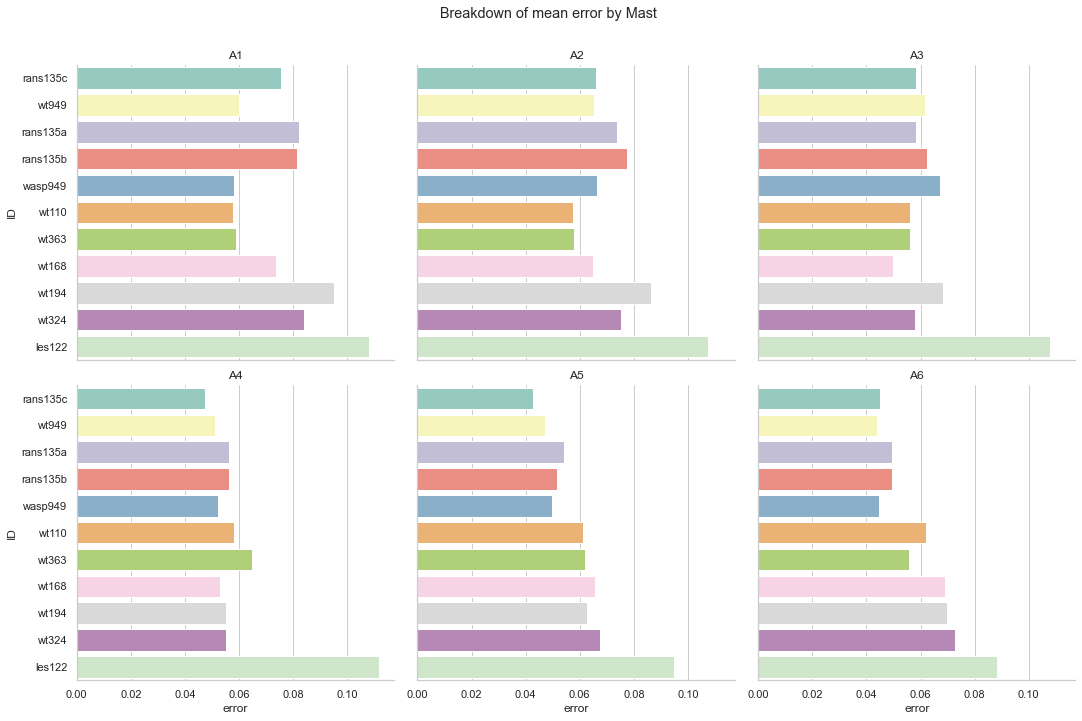

In [14]:
df_plot = df_error.groupby(['ID', 'mast']).mean().reset_index()
df_plot.sort_values(by=['mast', 'ID'], key=lambda x: x.map(saved_sort_order), inplace=True)
g = sns.catplot(x="error", y="ID", col='mast', col_wrap=3, kind="bar", data=df_plot)
g.fig.suptitle("Breakdown of mean error by Mast")
g.fig.subplots_adjust(top=.9)
g.set_titles('{col_name}')

{'linear': 0, 'rans': 1, 'les': 3, 'obs': 4, 'u': 0, 'n': 1, 's': 2, 'Unstable': 0, 'Neutral': 1, 'Stable': 2, '1': 1, '2': 2, '3': 3, '35': 35, '36': 36, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, 'rans135c': 0, 'wt949': 1, 'rans135a': 2, 'rans135b': 3, 'wasp949': 4, 'wt110': 5, 'wt363': 6, 'wt168': 7, 'wt194': 8, 'wt324': 9, 'les122': 10}


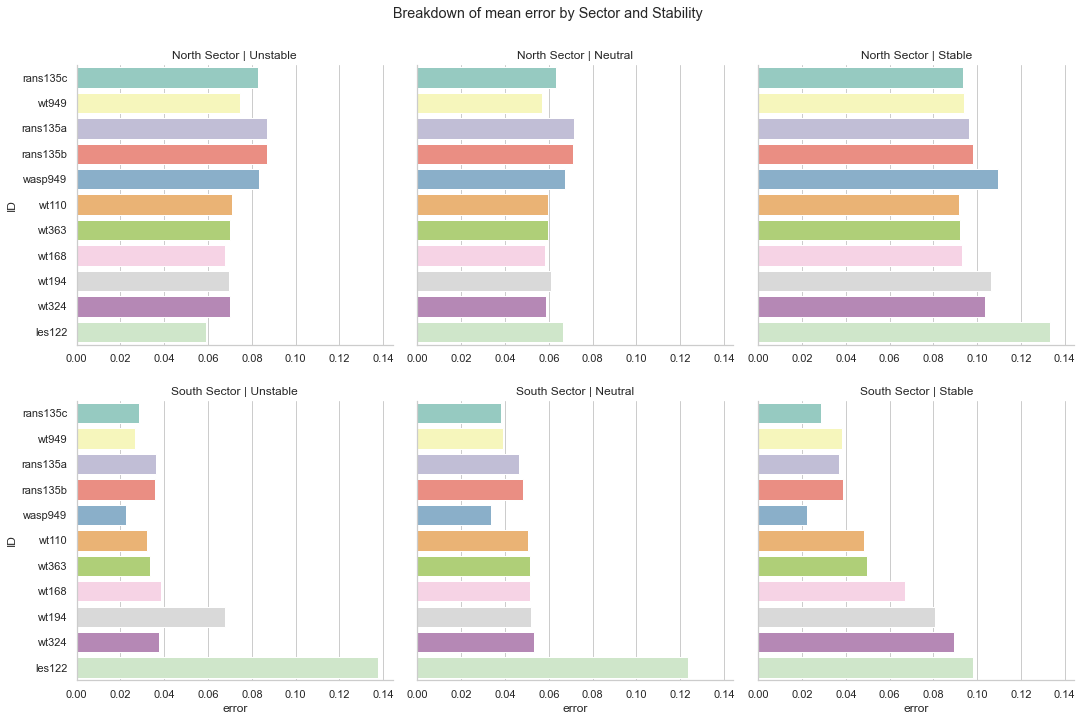

In [15]:
custom_dict = {'linear': 0, 'rans': 1, 'les': 3, 'obs' : 4, 'u':0,'n':1,'s':2, 'Unstable':0,'Neutral':1,'Stable':2, '1':1, '2':2, '3':3, '35':35, '36':36, '16':16, '17':17, '18':18, '19':19, '20':20} 
custom_dict.update(saved_sort_order)
print(custom_dict)

df_plot = df_error.groupby(['ID', 'Stability', 'nors']).mean().reset_index()
df_plot.sort_values(by=['nors', 'Stability', 'ID'], key=lambda x: x.map(custom_dict), inplace=True)

sns.set_theme(style="ticks", color_codes=True)
sns.set(style="whitegrid", palette="Set3")
g = sns.catplot(x="error", y="ID", col='Stability', row='nors', kind="bar", data=df_plot)
g.fig.suptitle("Breakdown of mean error by Sector and Stability")
g.fig.subplots_adjust(top=.9)
g.set_titles('{row_name} Sector' ' | ' '{col_name}')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)

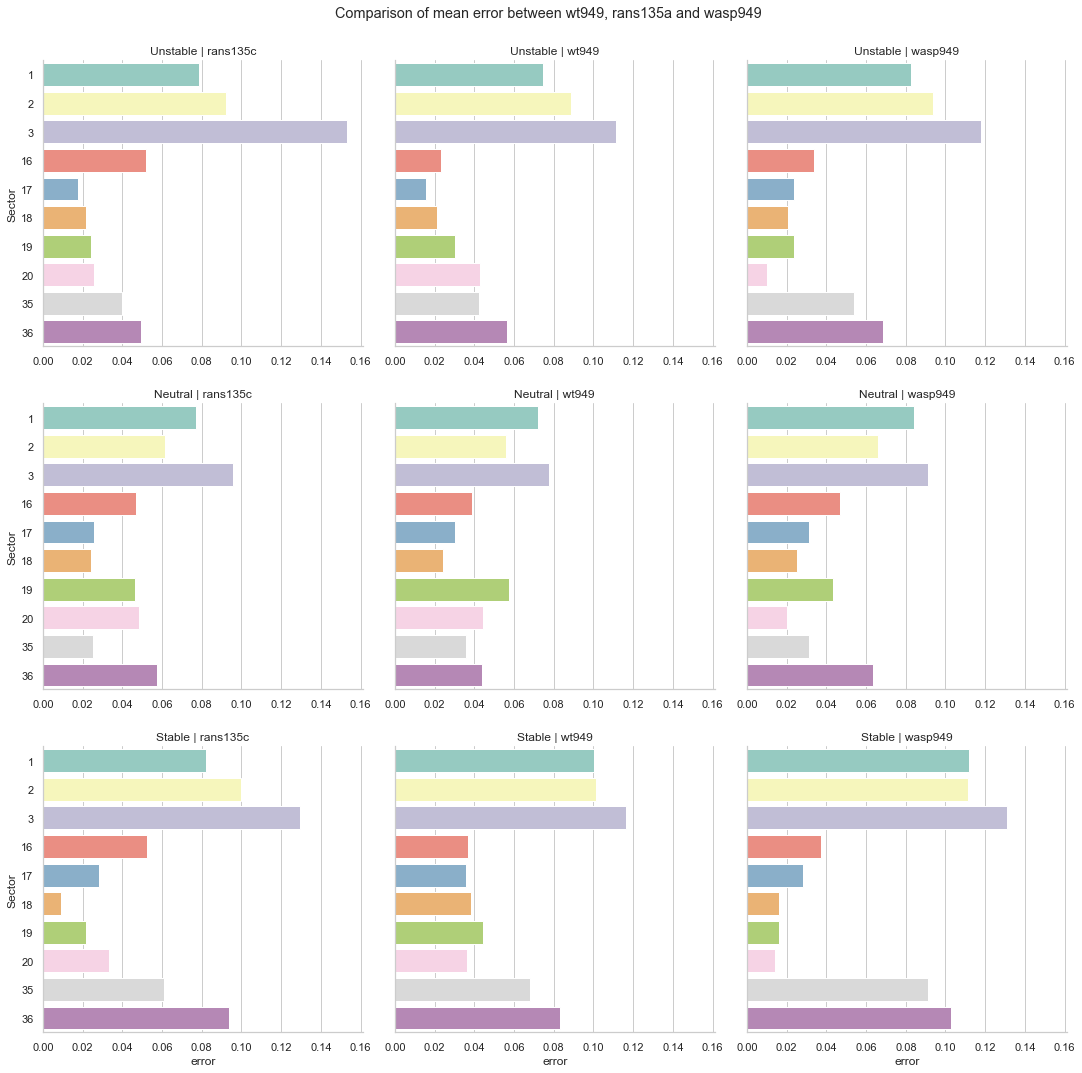

In [16]:
df_plot = df_error[(df_error.ID.isin(['wt949', 'wasp949', 'rans135c']))].groupby(['ID', 'Sector', 'Stability']).mean().reset_index()
df_plot.sort_values(by=['ID', 'Sector', 'Stability'], key=lambda x: x.map(custom_dict), inplace=True)

sns.set_theme(style="ticks", color_codes=True)
sns.set(style="whitegrid", palette="Set3")
g = sns.catplot(x="error", y="Sector", col='ID', row='Stability', kind="bar", data=df_plot)
g.fig.suptitle("Comparison of mean error between wt949, rans135a and wasp949")
g.fig.subplots_adjust(top=.93)
g.set_titles('{row_name}' ' | ' '{col_name}')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)

### FCF profiles

In [17]:
df_fcf = ds_all['flow_correction_factor'].to_dataframe()
df_fcf = df_fcf[df_fcf['flow_correction_factor'].notna()]
df_fcf = df_fcf[df_fcf['nors']!='']
df_fcf = df_fcf.reset_index()
df_fcf = df_fcf.replace({'Stability': 'u'}, 'Unstable')
df_fcf = df_fcf.replace({'Stability': 'n'}, 'Neutral')
df_fcf = df_fcf.replace({'Stability': 's'}, 'Stable')

#### Verification

In [18]:
df_plot = df_fcf.groupby(['ID', 'mast', 'Stability', 'Sector', 'z']).mean().reset_index()
df_plot.loc[(df_plot.ID=='rans135c') & (df_plot.z== 118) & (df_plot.Stability=='Neutral') & (df_plot.mast=='A1')].sort_values(by=['Sector'], key=lambda x: x.map(custom_dict))

df_error.loc[(df_error.ID=='rans135c') & (df_error.Stability=='Neutral') & (df_error.mast=='A1')].sort_values(by=['Sector'], key=lambda x: x.map(custom_dict))

,ID,Sector,Stability,mast,error,errorw,simtype,nors
1080,rans135c,1,Neutral,A1,0.139105,0.064652,rans,North
1107,rans135c,2,Neutral,A1,0.149758,0.064652,rans,North
1134,rans135c,3,Neutral,A1,0.173959,0.064652,rans,North
1215,rans135c,16,Neutral,A1,0.032087,0.064652,rans,South
1242,rans135c,17,Neutral,A1,0.006347,0.064652,rans,South
1269,rans135c,18,Neutral,A1,0.009894,0.064652,rans,South
1296,rans135c,19,Neutral,A1,0.054951,0.064652,rans,South
1323,rans135c,20,Neutral,A1,0.051434,0.064652,rans,South
1161,rans135c,35,Neutral,A1,0.002288,0.064652,rans,North
1188,rans135c,36,Neutral,A1,0.052102,0.064652,rans,North


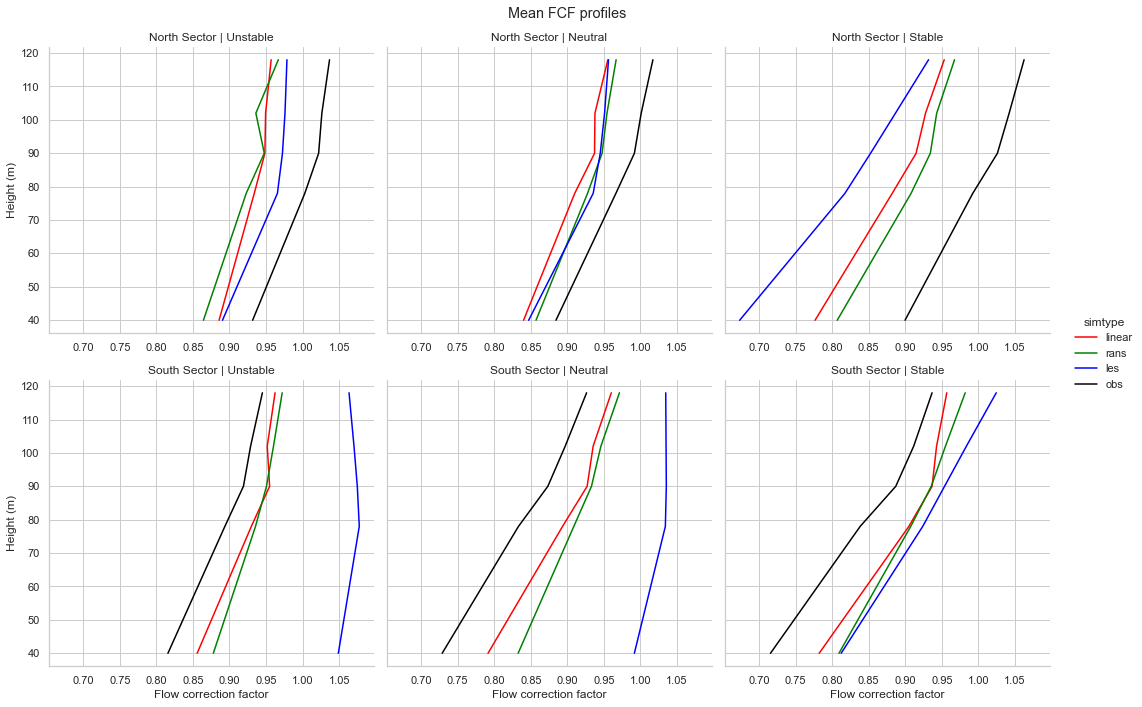

In [19]:
sns.set_theme(style="whitegrid")

# Create an array with the colors you want to use
colors = ['red', 'green', 'blue', 'black']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

df_plot = df_fcf.groupby(['simtype', 'z', 'Stability', 'nors']).mean().reset_index()
df_plot.sort_values(by=['simtype', 'Stability'], key=lambda x: x.map(custom_dict), inplace=True)

g = sns.relplot(data=df_plot, x="flow_correction_factor", y="z", sort=False, col='Stability', row='nors', hue='simtype', kind='line', palette = customPalette)

g.set_axis_labels("Flow correction factor", "Height (m)")
g.set_titles('{row_name} Sector' ' | ' '{col_name}')
g.fig.suptitle("Mean FCF profiles")
g.fig.subplots_adjust(top=.9)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)
g.tight_layout()
#g.savefig("facet_plot.png")